# Softmax

## 1. Download the CIFAR10 datasets, and load it

You have two ways to download the CIFAR10 datasets:
- cd the path to './CIFAR10/datasets/', and run the 'get_datasets.sh'. Then it will automatically download the datasets and decompress it.
- Enter the CIFAR10 website: http://www.cs.toronto.edu/~kriz/cifar.html and manually download the python version. Then put the datasets in local folder './CIFAR10/datasets/'.

The CIFAR10 datasets named 'cifar-10-batches-py/'

### Setup code

In [20]:
# Run some setup code for this notebook.

import random
import numpy as np
from CIFAR10.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the CIFAR10 dataset

In [21]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'CIFAR10/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


### Show some CIFAR10 images

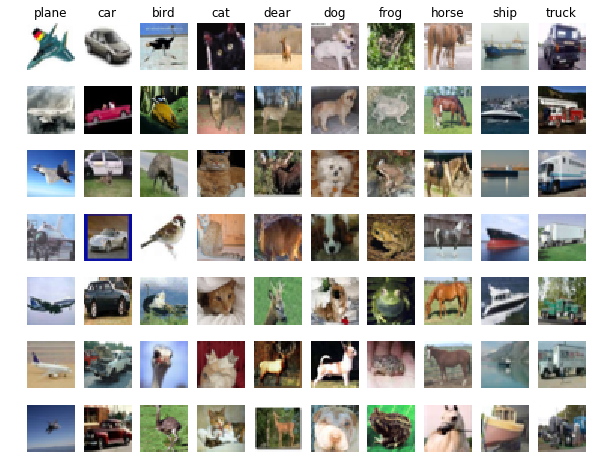

In [22]:
classes = ['plane', 'car', 'bird', 'cat', 'dear', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
num_each_class = 7

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, num_each_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + (y + 1)
        plt.subplot(num_each_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

### Subsample the data for more efficient code execution

In [23]:
# Split the data into train, val, test sets and dev sets
num_train = 49000
num_val = 1000
num_test = 1000
num_dev = 500

# Validation set
mask = range(num_train, num_train + num_val)
X_val = X_train[mask]
y_val = y_train[mask]

# Train set
mask = range(num_train)
X_train = X_train[mask]
y_train = y_train[mask]

# Test set
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

# Development set
mask = np.random.choice(num_train, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development　data shape: ', X_dev.shape)
print('Development labels shape: ', y_dev.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
Development　data shape:  (500, 32, 32, 3)
Development labels shape:  (500,)


## 2. Preprocessing

### Reshape the images data into rows

In [24]:
# Preprocessing: reshape the images data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

print('Train data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('Development data shape: ', X_dev.shape)

Train data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
Development data shape:  (500, 3072)


### Subtract the mean images

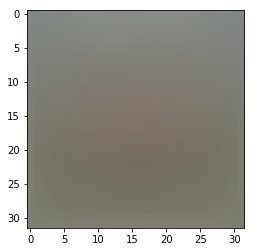

In [25]:
# Processing: subtract the mean images
mean_image = np.mean(X_train, axis=0)
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8'))
plt.show()

In [26]:
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

### Append the bias dimension of ones

In [27]:
# append the bias dimension of ones (i.e. bias trick)
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
print('Train data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('Development data shape: ', X_dev.shape)

Train data shape:  (49000, 3073)
Validation data shape:  (1000, 3073)
Test data shape:  (1000, 3073)
Development data shape:  (500, 3073)


## 3. Define a linear Softmax classifier

In [28]:
class Softmax(object):
    def __init__(self):
        self.W = None
    
    def loss_naive(self, X, y, reg):
        """
        Structured Softmax loss function, naive implementation (with loops).
        Inputs:
        - X: A numpy array of shape (num_train, D) contain the training data
          consisting of num_train samples each of dimension D
        - y: A numpy array of shape (num_train,) contain the training labels,
          where y[i] is the label of X[i]
        - reg: float, regularization strength
        Return:
        - loss: the loss value between predict value and ground truth
        - dW: gradient of W
        """
        
        # Initialize loss and dW
        loss = 0.0
        dW = np.zeros(self.W.shape)
        
        # Compute the loss and dW
        num_train = X.shape[0]
        num_classes = self.W.shape[1]
        for i in range(num_train):
            scores = np.dot(X[i], self.W)
            scores -= np.max(scores)
            correct_class = y[i]
            correct_score = scores[correct_class]
            loss_i = -correct_score + np.log(np.sum(np.exp(scores)))
            loss += loss_i
            for j in range(num_classes):
                softmax_output = np.exp(scores[j]) / np.sum(np.exp(scores))
                if j == correct_class:
                    dW[:,j] += (-1 + softmax_output) * X[i,:]
                else:
                    dW[:,j] += softmax_output * X[i,:]
        
        loss /= num_train
        loss += 0.5 * reg * np.sum(self.W * self.W)
        dW /= num_train
        dW += reg * self.W
        
        return loss, dW
    
    def loss_vectorized(self, X, y, reg):
        """
        Structured Softmax loss function, vectorized implementation (without loops).
        Inputs:
        - X: A numpy array of shape (num_train, D) contain the training data
          consisting of num_train samples each of dimension D
        - y: A numpy array of shape (num_train,) contain the training labels,
          where y[i] is the label of X[i]
        - reg: float, regularization strength
        Return:
        - loss: the loss value between predict value and ground truth
        - dW: gradient of W
        """
        
        # Initialize loss and dW
        loss = 0.0
        dW = np.zeros(self.W.shape)
        
        # Compute the loss and dW
        num_train = X.shape[0]
        num_classes = self.W.shape[1]
        
        # loss
        scores = np.dot(X, self.W)
        scores -= np.max(scores, axis=1).reshape(-1, 1)
        softmax_output = np.exp(scores) / np.sum(np.exp(scores), axis=1).reshape(-1, 1)
        loss = np.sum(-np.log(softmax_output[range(softmax_output.shape[0]), list(y)]))
        loss /= num_train
        loss += 0.5 * reg * np.sum(self.W * self.W)
        
        # dW
        dS = softmax_output
        dS[range(dS.shape[0]), list(y)] += -1
        dW = np.dot(X.T, dS)
        dW /= num_train
        dW += reg * self.W
        
        return loss, dW
    
    def train(self, X, y, learning_rate = 1e-3, reg = 1e-5, num_iters = 100, 
             batch_size = 200, print_flag = False):
        """
        Train Softmax classifier using SGD
        Inputs:
        - X: A numpy array of shape (num_train, D) contain the training data
          consisting of num_train samples each of dimension D
        - y: A numpy array of shape (num_train,) contain the training labels,
          where y[i] is the label of X[i], y[i] = c, 0 <= c <= C
        - learning rate: (float) learning rate for optimization
        - reg: (float) regularization strength
        - num_iters: (integer) numbers of steps to take when optimization
        - batch_size: (integer) number of training examples to use at each step
        - print_flag: (boolean) If true, print the progress during optimization
        Outputs:
        - loss_history: A list containing the loss at each training iteration
        """
        
        loss_history = []
        num_train = X.shape[0]
        dim = X.shape[1]
        num_classes = np.max(y) + 1
        
        # Initialize W
        if self.W == None:
            self.W = 0.001 * np.random.randn(dim, num_classes)
        
        # iteration and optimization
        for t in range(num_iters):
            idx_batch = np.random.choice(num_train, batch_size, replace=True)
            X_batch = X[idx_batch]
            y_batch = y[idx_batch]
            loss, dW = self.loss_vectorized(X_batch, y_batch, reg)
            loss_history.append(loss)
            self.W += -learning_rate * dW
            
            if print_flag and t%100 == 0:
                print('iteration %d / %d: loss %f' % (t, num_iters, loss))
        
        return loss_history
    
    def predict(self, X):
        """
        Use the trained weights of Softmax to predict data labels
        Inputs:
        - X: A numpy array of shape (num_train, D) contain the training data
        Outputs:
        - y_pred: A numpy array, predicted labels for the data in X
        """
        
        y_pred = np.zeros(X.shape[0])
        scores = np.dot(X, self.W)
        y_pred = np.argmax(scores, axis=1)
        
        return y_pred        

## 4. Gradient Check

### Define loss function

In [29]:
def loss_naive1(X, y, W, reg):
    """
    Structured Softmax loss function, naive implementation (with loops).
    Inputs:
    - X: A numpy array of shape (num_train, D) contain the training data
      consisting of num_train samples each of dimension D
    - y: A numpy array of shape (num_train,) contain the training labels,
      where y[i] is the label of X[i]
    - W: A numpy array of shape (D, C) contain the weights
    - reg: float, regularization strength
    Return:
    - loss: the loss value between predict value and ground truth
    - dW: gradient of W
    """
        
    # Initialize loss and dW
    loss = 0.0
    dW = np.zeros(W.shape)
        
    # Compute the loss and dW
    num_train = X.shape[0]
    num_classes = W.shape[1]
    for i in range(num_train):
        scores = np.dot(X[i], W)
        scores -= np.max(scores)
        correct_class = y[i]
        correct_score = scores[correct_class]
        loss_i = -correct_score + np.log(np.sum(np.exp(scores)))
        loss += loss_i
        for j in range(num_classes):
            softmax_output = np.exp(scores[j]) / np.sum(np.exp(scores))
            if j == correct_class:
                dW[:,j] += (-1 + softmax_output) * X[i,:]
            else:
                dW[:,j] += softmax_output * X[i,:]
        
    loss /= num_train
    loss += 0.5 * reg * np.sum(W * W)
    dW /= num_train
    dW += reg * W
        
    return loss, dW

def loss_vectorized1(X, y, W, reg):
    """
    Structured Softmax loss function, vectorized implementation (without loops).
    Inputs:
    - X: A numpy array of shape (num_train, D) contain the training data
      consisting of num_train samples each of dimension D
    - y: A numpy array of shape (num_train,) contain the training labels,
      where y[i] is the label of X[i]
    - W: A numpy array of shape (D, C) contain the weights
    - reg: float, regularization strength
    Return:
    - loss: the loss value between predict value and ground truth
    - dW: gradient of W
    """
        
    # Initialize loss and dW
    loss = 0.0
    dW = np.zeros(W.shape)
        
    # Compute the loss and dW
    num_train = X.shape[0]
    num_classes = W.shape[1]
        
    # loss
    scores = np.dot(X, W)
    scores -= np.max(scores, axis=1).reshape(-1, 1)
    softmax_output = np.exp(scores) / np.sum(np.exp(scores), axis=1).reshape(-1, 1)
    loss = np.sum(-np.log(softmax_output[range(softmax_output.shape[0]), list(y)]))
    loss /= num_train
    loss += 0.5 * reg * np.sum(W * W)
        
    # dW
    dS = softmax_output
    dS[range(dS.shape[0]), list(y)] += -1
    dW = np.dot(X.T, dS)
    dW /= num_train
    dW += reg * W
        
    return loss, dW

### Gradient check

In [30]:
from gradient_check import grad_check_sparse
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

# Without regularization
loss, dW = loss_naive1(X_dev, y_dev, W, 0)
f = lambda W: loss_naive1(X_dev, y_dev, W, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, dW)

# With regularization
loss, dW = loss_naive1(X_dev, y_dev, W, 5e1)
f = lambda W: loss_naive1(X_dev, y_dev, W, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, dW)

numerical: -0.543558 analytic: -0.543558, relative error: 8.221665e-08
numerical: -2.860886 analytic: -2.860886, relative error: 2.599433e-08
numerical: 1.685298 analytic: 1.685298, relative error: 2.594597e-10
numerical: 0.116803 analytic: 0.116803, relative error: 1.379942e-07
numerical: -5.214666 analytic: -5.214666, relative error: 8.845752e-09
numerical: 1.795245 analytic: 1.795245, relative error: 7.215048e-09
numerical: 1.560274 analytic: 1.560274, relative error: 1.872290e-08
numerical: 2.148445 analytic: 2.148445, relative error: 2.614330e-08
numerical: -0.602778 analytic: -0.602778, relative error: 1.068035e-08
numerical: -3.830486 analytic: -3.830486, relative error: 5.794995e-09
numerical: -0.630750 analytic: -0.630750, relative error: 1.059528e-08
numerical: 0.551364 analytic: 0.551364, relative error: 1.550874e-07
numerical: -1.510740 analytic: -1.510740, relative error: 1.834765e-08
numerical: 1.076586 analytic: 1.076586, relative error: 1.316254e-09
numerical: 0.449311 

### loss_naive vs. loss_vectorized

In [31]:
t_st = time.time()
loss_naive, dW_naive = loss_naive1(X_dev, y_dev, W, 0.00005)
t_ed = time.time()
print('Naive loss: %e computed in %f seconds.' % (loss_naive, t_ed - t_st))
t_st = time.time()
loss_vectorized, dW_vectorized = loss_vectorized1(X_dev, y_dev, W, 0.00005)
t_ed = time.time()
print('Vectorized loss: %e computed in %f seconds.' % (loss_vectorized, t_ed - t_st))

diff_loss = loss_naive - loss_vectorized
diff_dW = np.linalg.norm(dW_naive - dW_vectorized, ord='fro')
print('Difference of loss: %f' % diff_loss)
print('Difference of dW: %f' % diff_dW)

Naive loss: 2.380674e+00 computed in 0.193738 seconds.
Vectorized loss: 2.380674e+00 computed in 0.008883 seconds.
Difference of loss: 0.000000
Difference of dW: 0.000000


## 4. Stochastic Gradient Descent

In [32]:
softmax = Softmax()
loss_history = softmax.train(X_train, y_train, learning_rate = 1e-7, reg = 2.5e4, num_iters = 1500, 
             batch_size = 200, print_flag = True)

iteration 0 / 1500: loss 395.405122
iteration 100 / 1500: loss 239.163069
iteration 200 / 1500: loss 145.283059
iteration 300 / 1500: loss 88.674166
iteration 400 / 1500: loss 54.545590
iteration 500 / 1500: loss 33.744960
iteration 600 / 1500: loss 21.223324
iteration 700 / 1500: loss 13.646624
iteration 800 / 1500: loss 9.017569
iteration 900 / 1500: loss 6.239408
iteration 1000 / 1500: loss 4.572118
iteration 1100 / 1500: loss 3.584454
iteration 1200 / 1500: loss 2.985270
iteration 1300 / 1500: loss 2.629507
iteration 1400 / 1500: loss 2.396192


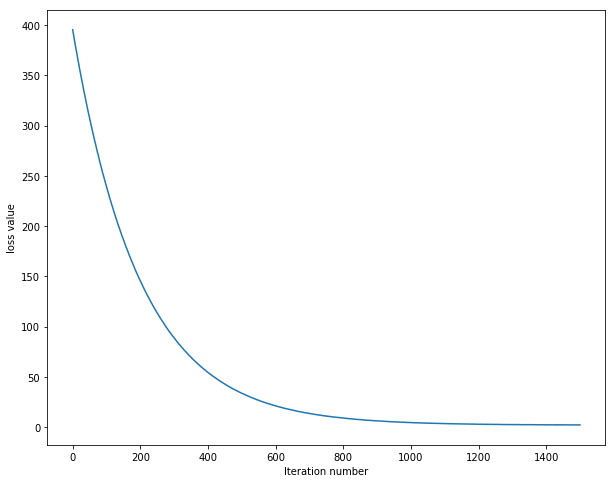

In [33]:
# Plot the loss_history
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('loss value')
plt.show()

In [ ]:
# Use softmax classifier to predict
# Training set
y_pred = softmax.predict(X_train)
num_correct = np.sum(y_pred == y_train)
accuracy = np.mean(y_pred == y_train)
print('Training correct %d/%d: The accuracy is %f' % (num_correct, X_train.shape[0], accuracy))

# Test set
y_pred = softmax.predict(X_test)
num_correct = np.sum(y_pred == y_test)
accuracy = np.mean(y_pred == y_test)
print('Test correct %d/%d: The accuracy is %f' % (num_correct, X_test.shape[0], accuracy))

Training correct 17193/49000: The accuracy is 0.350878
Test correct 364/1000: The accuracy is 0.364000


## 5. Validation and Test

### Cross-validation

In [ ]:
learning_rates = [1.4e-7, 1.5e-7, 1.6e-7]
regularization_strengths = [8000.0, 9000.0, 10000.0, 11000.0, 18000.0, 19000.0, 20000.0, 21000.0]

results = {}
best_lr = None
best_reg = None
best_val = -1   # The highest validation accuracy that we have seen so far.
best_softmax = None # The LinearSVM object that achieved the highest validation rate.

for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        loss_history = softmax.train(X_train, y_train, learning_rate = lr, reg = reg, num_iters = 3000)
        y_train_pred = softmax.predict(X_train)
        accuracy_train = np.mean(y_train_pred == y_train)
        y_val_pred = softmax.predict(X_val)
        accuracy_val = np.mean(y_val_pred == y_val)
        results[(lr, reg)] = accuracy_train, accuracy_val
        if accuracy_val > best_val:
            best_lr = lr
            best_reg = reg
            best_val = accuracy_val
            best_softmax = softmax
        print('lr: %e reg: %e train accuracy: %f val accuracy: %f' %
              (lr, reg, results[(lr, reg)][0], results[(lr, reg)][1]))
print('Best validation accuracy during cross-validation:\nlr = %e, reg = %e, best_val = %f' %
      (best_lr, best_reg, best_val)) 

lr: 1.400000e-07 reg: 8.000000e+03 train accuracy: 0.378204 val accuracy: 0.382000
lr: 1.400000e-07 reg: 9.000000e+03 train accuracy: 0.374837 val accuracy: 0.390000
lr: 1.400000e-07 reg: 1.000000e+04 train accuracy: 0.373429 val accuracy: 0.381000
lr: 1.400000e-07 reg: 1.100000e+04 train accuracy: 0.372633 val accuracy: 0.384000
lr: 1.400000e-07 reg: 1.800000e+04 train accuracy: 0.359939 val accuracy: 0.380000
lr: 1.400000e-07 reg: 1.900000e+04 train accuracy: 0.358592 val accuracy: 0.362000
lr: 1.400000e-07 reg: 2.000000e+04 train accuracy: 0.358020 val accuracy: 0.374000
lr: 1.400000e-07 reg: 2.100000e+04 train accuracy: 0.356918 val accuracy: 0.366000
lr: 1.500000e-07 reg: 8.000000e+03 train accuracy: 0.380347 val accuracy: 0.397000
lr: 1.500000e-07 reg: 9.000000e+03 train accuracy: 0.375490 val accuracy: 0.388000
lr: 1.500000e-07 reg: 1.000000e+04 train accuracy: 0.373347 val accuracy: 0.390000
lr: 1.500000e-07 reg: 1.100000e+04 train accuracy: 0.373061 val accuracy: 0.393000
lr: 

### Visualize the cross-validation result

In [ ]:
import math

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

maker_size = 100
plt.figure(figsize=(10,10))

# training accuracy
plt.subplot(2, 1, 1)
colors = [results[x][0] for x in results]
plt.scatter(x_scatter, y_scatter, maker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')

# validation accuracy
plt.subplot(2, 1, 2)
colors = [results[x][1] for x in results]
plt.scatter(x_scatter, y_scatter, maker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.show()

### Use the best softmax to test

In [ ]:
y_pred = best_softmax.predict(X_test)
num_correct = np.sum(y_pred == y_test)
accuracy = np.mean(y_pred == y_test)
print('Test correct %d/%d: The accuracy is %f' % (num_correct, num_test, accuracy))

### Visualize the weights for each class

In [ ]:
W = best_softmax.W[:-1,:]    # delete the bias
W = np.reshape(W, (32, 32, 3, 10))
W_max, W_min = np.max(W), np.min(W)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    # Rescale the weights to be between 0 and 255
    imgW = 255.0 * (W[:,:,:,i] - W_min) / (W_max - W_min)
    plt.imshow(imgW.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])